In [13]:
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import harmonypy as hm
import faiss

import scSLAT
from scSLAT.model import run_SLAT_multi,load_anndatas, Cal_Spatial_Net, run_SLAT, scanpy_workflow, spatial_match
from scSLAT.viz import match_3D_multi, build_3D, hist, Sankey, match_3D_celltype
from scSLAT.metrics import region_statistics

In [2]:
adata1 = sc.read_h5ad('../../data/xenium/breast/data1_split.h5ad')
adata2 = sc.read_h5ad('../../data/visium/breast/data3_split.h5ad')

In [5]:
adata_all = adata1.concatenate(adata2)
adata_all = scanpy_workflow(adata_all)
harm = hm.run_harmony(adata_all.obsm['X_pca'], adata_all.obs, 'batch', max_iter_harmony=20)
Z = harm.Z_corr.T
adata_all.obsm['X_harmony'] = Z

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
2023-01-24 14:45:39,558 - harmonypy - INFO - Iteration 1 of 20
2023-01-24 14:46:26,930 - harmonypy - INFO - Iteration 2 of 20
2023-01-24 14:47:12,684 - harmonypy - INFO - Iteration 3 of 20
2023-01-24 14:47:57,614 - harmonypy - INFO - Iteration 4 of 20
2023-01-24 14:48:42,949 - harmonypy - INFO - Iteration 5 of 20
2023-01-24 14:49:28,918 - harmonypy - INFO - Converged after 5 iterations


In [8]:
adata1.obsm['X_harmony'] = Z[:adata1.shape[0],:]
adata2.obsm['X_harmony'] = Z[adata1.shape[0]:,:]
embd0 = torch.from_numpy(adata1.obsm['X_harmony'])
embd1 = torch.from_numpy(adata2.obsm['X_harmony'])

In [10]:
best, index, distance = spatial_match([embd1, embd0], reorder=False)
matching = np.array([range(index.shape[0]), best])

In [11]:
adata1_df = pd.DataFrame({'index':range(embd0.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'leiden':adata1.obs['leiden']})
adata2_df = pd.DataFrame({'index':range(embd1.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'leiden':adata2.obs['leiden']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match,start=0.5,number_of_interval=10)

0.500~0.550       608          0.604%
0.550~0.600      2302          2.287%
0.600~0.650      7353          7.306%
0.650~0.700     18668         18.549%
0.700~0.750     32207         32.002%
0.750~0.800     29057         28.872%
0.800~0.850      9560          9.499%
0.850~0.900       752          0.747%
0.900~0.950        17          0.017%
0.950~1.000         0          0.000%


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 11 cell types; dataset2: 11 cell types; 
                    Total :11 celltypes; Overlap: 11 cell types 
                    Not overlap :[[]]
Subsample 300 cell pairs from 100642


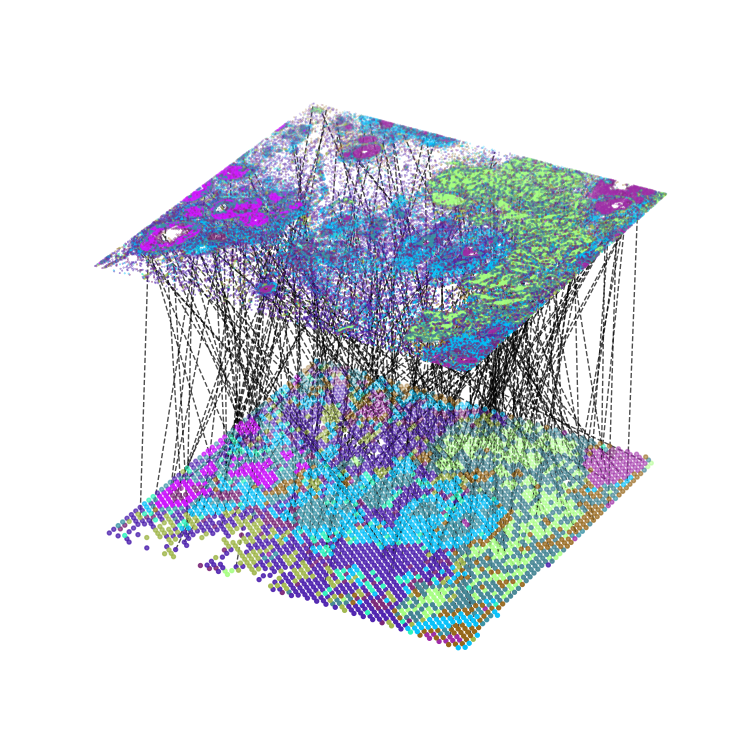

In [12]:
multi_align = match_3D_multi(adata2_df, adata1_df, matching, meta='leiden',
                            scale_coordinate=True, subsample_size=300)

multi_align.draw_3D(size=[13, 9.5], line_width=1, point_size=[8, 0.1],
                    line_color='black', show_error=False, hide_axis=True)

# Subset View

In [14]:
TP_Xenium_coord = pd.read_csv('../../data/xenium/breast/TP_coordinates.csv')
ref_coord = adata1.obsm['spatial'].astype('float32').copy()

In [15]:
query_coord = TP_Xenium_coord.iloc[:,1:].to_numpy() * -1
query_coord = query_coord.astype('float32').copy()

In [16]:
index = faiss.IndexFlatL2(2) 
index.add(ref_coord)   
distance, order = index.search(query_coord, 2)

In [17]:
TP_Xenium_barcode = adata1.obs_names[order[:,0]]
TP_Xenium_index = list(set(order[:,0]))

In [18]:
TP_matching = matching[:,TP_Xenium_index]
unique_elements, frequency = np.unique(TP_matching[1,:], return_counts=True)
sorted_indexes = np.argsort(frequency)[::-1]
sorted_by_freq = unique_elements[sorted_indexes]

/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 11 cell types; dataset2: 11 cell types; 
                    Total :11 celltypes; Overlap: 11 cell types 
                    Not overlap :[[]]
Subsample 10 cell pairs from 94


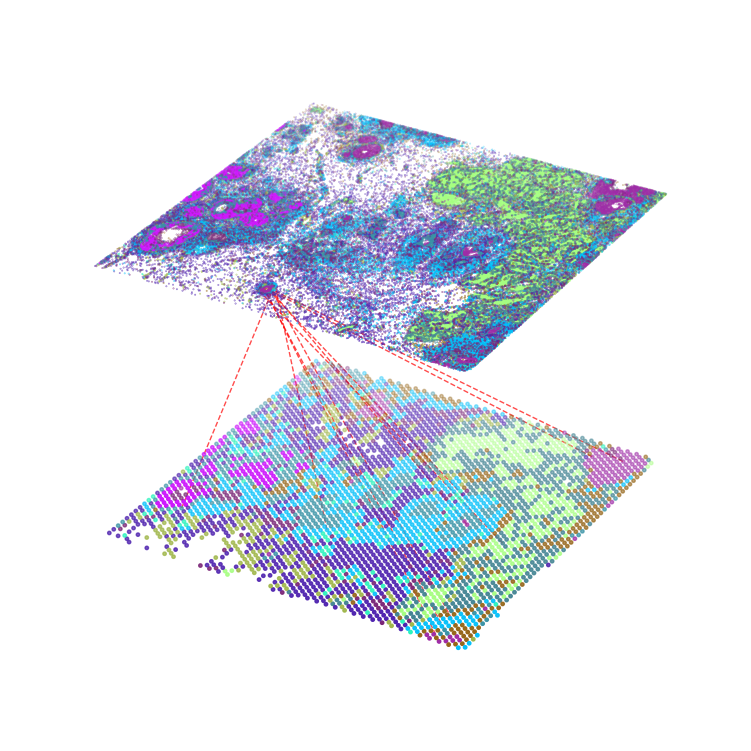

In [19]:
multi_align = match_3D_multi(adata2_df, adata1_df, matching,meta='leiden',
                            scale_coordinate=True, subsample_size=10, subset=list(set(order[:,0])))

multi_align.draw_3D(size=[13, 9.5], line_width=1 ,point_size=[6,0.1], show_error=False, hide_axis=True, line_color='red')